### Importing and installing all important Libraries

In [1]:
!pip install plotly
!pip install matplotlib_scalebar

In [2]:
import pandas as pd
import numpy as np
import os
import fiona
import folium
import requests
import matplotlib
import geopandas as gpd
import plotly.express as px
from pyproj import Transformer
from folium.plugins import Draw
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from folium.plugins import BeautifyIcon
from sklearn.cluster import MiniBatchKMeans
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.font_manager import FontProperties
from shapely.geometry import Point, LineString, Polygon
from math import floor
from scipy.spatial import KDTree
import math

/Users/kruthikaramesh/opt/anaconda3/envs/newenv/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_69158/2649238859.py:8: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups

## Defining Important Functions

In [32]:
def boundary_check(data,longitude,latitude):
    to_del = []
    long_del_east = data[data[longitude] > 0.4].index.to_list()
    long_del_west = data[data[longitude] <-0.5].index.to_list()
    lat_del_upper = data[data[latitude] >51.7].index.to_list()
    lat_del_lower = data[data[latitude] <51.2].index.to_list()

    to_del.extend(long_del_east)
    to_del.extend(long_del_west)
    to_del.extend(lat_del_upper)
    to_del.extend(lat_del_lower)
    to_del = set(to_del)
    return to_del

In [4]:
def crs_def(gdf):
    gdf.crs = "EPSG:4326" #Adding crs information to geodataframe
    gdf.plot(marker = '*', color = 'green') #Plotting the geodataframe
    plt.rcParams['figure.figsize'] = [10, 10] 

In [5]:
def london_map(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
    uk = world[world['name'] == 'United Kingdom']

    ax = uk.plot(color ='#e3bccf', edgecolor = 'black')
    plt.rcParams['figure.figsize'] = [10, 10] 

    # for x, y, label in zip(uk.geometry.representative_point().x, uk.geometry.representative_point().y, africa_gdf.name):
    #ax.annotate(label, xy=(x, y))
    
    gdf.plot(ax=ax, color = 'blue')

In [6]:
def london_shapefile():
    gpd.options.use_pygeos = True  # optional, for improved performance
    gpd.options._config['SHAPE_RESTORE_SHX'] = 'YES'
    london_shapefile = gpd.read_file("London Population /London_Borough_Excluding_MHW.shp")
    london_shapefile.crs #crs here is projected wherea~s points geodataframe ('gdf') is geographic crs as seen in the next cell
    london_shapefile['geometry'].to_crs(epsg=4326)#, allow_override=True)
    london_new = london_shapefile.to_crs(epsg=4326)#, allow_override=True)
    return london_new

In [7]:
def overlap_london(gdf,london_new):
    ax =london_new.plot(edgecolor='white',color='black')
    gdf.plot(ax=ax, marker='*',color ='red')
    plt.rcParams['figure.figsize']= [10, 10]  #Some points are shown outside the boundary of london but can be ignored for now

In [8]:
def MINDIST(grid_cell, user_coords, epsilon):
    gx = grid_cell[0] * grid_side_length + grid_side_length / 2
    gy = grid_cell[1] * grid_side_length + grid_side_length / 2
    x, y = user_coords

    if abs(gx - x) > epsilon:
        xg = math.ceil(x / grid_side_length) * grid_side_length
    else:
        xg = math.floor(x / grid_side_length) * grid_side_length

    if abs(gy - y) > epsilon:
        yg = math.ceil(y / grid_side_length) * grid_side_length
    else:
        yg = math.floor(y / grid_side_length) * grid_side_length

    return math.sqrt((xg - x) ** 2 + (yg - y) ** 2)

### Reading Data
Two datasets used are:
1. Restaurant data
2. User data

The dataset is cleaned and plotted on the map to visualise all the restaurants and user with their location.

### 1. Restaurant Data

In [9]:
raw_restaurant_data = pd.read_csv("London Population /Cleaned_restaurants.csv")

In [10]:
raw_restaurant_data

,Unnamed: 0,Address,Business Name,Business Type,BusinessTypeID,FHRSID,Latitude,Longitude,Local Authority BusinessID,Local Authority Code,...,Local Authority WebSite,New Rating Pending,Post Code,Rating Key,Rating Value,Scheme Type,Confidence In Management,Hygiene,Structural,/Header/ItemCount/#agg
0,0,"432-434 Kingsland Road, London E8 4AA Hackney...","""MU""",Restaurant/Cafe/Canteen,1.0,1584416.0,NaN,NaN,HAC1603,512.0,...,https://hackney.gov.uk/environmental-health#food,False,E8 4AA,fhrs_5_en-GB,5,FHRS,5.0,5.0,0.0,NaN
1,1,Rio Cinema Dalston 103-107 Kingsland High Stre...,"""Rio Cinema""",Restaurant/Cafe/Canteen,1.0,468824.0,51.549539,-0.075568,1317,512.0,...,https://hackney.gov.uk/environmental-health#food,False,E8 2PB,fhrs_3_en-GB,3,FHRS,10.0,10.0,10.0,NaN
2,2,Railway Arch 214 Ponsford Street Hackney London,% Arabica,Manufacturers/packers,7839.0,1220366.0,51.547348,-0.048531,191074,512.0,...,https://hackney.gov.uk/environmental-health#food,False,E9 6JU,fhrs_2_en-GB,2,FHRS,10.0,5.0,15.0,NaN
3,3,Basement To Ground Floor 33 Broadway Market Ha...,%Arabica,Other catering premises,7841.0,1225476.0,51.536510,-0.062051,130435,512.0,...,https://hackney.gov.uk/environmental-health#food,False,E8 4PH,fhrs_5_en-GB,5,FHRS,5.0,5.0,5.0,NaN
4,4,45-47 lower Clapton road Hackney London,&organic ltd,Restaurant/Cafe/Canteen,1.0,1527059.0,51.550962,-0.052203,HAC1459,512.0,...,https://hackney.gov.uk/environmental-health#food,False,E50NS,fhrs_awaitinginspection_en-GB,AwaitingInspection,FHRS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78780,78780,,Zays Bakes,Other catering premises,7841.0,1498540.0,NaN,NaN,22/00135/COM,521.0,...,http://www.kingston.gov.uk,False,NaN,fhrs_5_en-GB,5,FHRS,5.0,0.0,0.0,NaN
78781,78781,43 Market Place Kingston Upon Thames,Zizzi And Coco Di Mama,Restaurant/Cafe/Canteen,1.0,1386687.0,51.408839,-0.306178,21/97574/RBK,521.0,...,http://www.kingston.gov.uk,False,KT1 1ET,fhrs_5_en-GB,5,FHRS,5.0,5.0,5.0,NaN
78782,78782,Kings Oak Primary School Dickerage Lane New Ma...,Zone All Sports And Care At Kings Oak Primary ...,School/college/university,7845.0,1594642.0,51.404842,-0.274529,23/00055/COM,521.0,...,http://www.kingston.gov.uk,False,KT3 3RZ,fhrs_5_en-GB,5,FHRS,5.0,5.0,0.0,NaN
78783,78783,Malden Manor Primary And Nursery School Sheeph...,Zone All Sports And Care At Malden Manor Primary,School/college/university,7845.0,1594643.0,NaN,NaN,23/00056/COM,521.0,...,http://www.kingston.gov.uk,True,KT3 5PF,fhrs_awaitinginspection_en-GB,AwaitingInspection,FHRS,NaN,NaN,NaN,NaN


From the above dataframe, we notice the presence of NAN and unwanted columns. So we begin to clean the dataset.

In [11]:
nonnulll_raw_restaurant_data = raw_restaurant_data.dropna(subset=['Latitude','Longitude'])

In [12]:
print(f'Before deletion of rows: {len(nonnulll_raw_restaurant_data)}')
rest_del = boundary_check(nonnulll_raw_restaurant_data,'Longitude','Latitude')
nonnulll_raw_restaurant_data = nonnulll_raw_restaurant_data.drop(index=rest_del)
print(f'After deletion of rows: {len(nonnulll_raw_restaurant_data)}')

Before deletion of rows: 64323
After deletion of rows: 64287


In [13]:
coordinates_restaurant_data = nonnulll_raw_restaurant_data[['Business Name ','Latitude','Longitude']]

### 2. User data

In [14]:
raw_user_data = pd.read_csv("London Population /london_postcodes-ons-postcodes-directory-feb22.csv")

In [15]:
raw_user_data

,pcd,pcd2,pcds,dointr,doterm,oscty,ced,oslaua,osward,parish,...,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp
0,BR1 1AA,BR1 1AA,BR1 1AA,201605,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,A1,4C3,51.401546,0.015415,E37000051,NaN,E23000001,24305,E56000010,E54000030
1,BR1 1AB,BR1 1AB,BR1 1AB,201203,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,A1,2D1,51.406333,0.015208,E37000051,NaN,E23000001,13716,E56000010,E54000030
2,BR1 1AD,BR1 1AD,BR1 1AD,201409,201709.0,E99999999,E99999999,E09000006,E05000109,E43000196,...,A1,4C3,51.400057,0.016715,E37000051,NaN,E23000001,24305,E56000010,E54000030
3,BR1 1AE,BR1 1AE,BR1 1AE,200808,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,A1,2D1,51.404543,0.014195,E37000051,NaN,E23000001,20694,E56000010,E54000030
4,BR1 1AF,BR1 1AF,BR1 1AF,201505,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,A1,4C3,51.401392,0.014948,E37000051,NaN,E23000001,24305,E56000010,E54000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326209,WD3 8UX,WD3 8UX,WD3 8UX,200010,NaN,E99999999,E99999999,E09000017,E05000330,E43000207,...,D1,5B2,51.624762,-0.494021,E37000051,NaN,E23000001,21531,E56000021,E54000027
326210,WD3 8UZ,WD3 8UZ,WD3 8UZ,200112,NaN,E99999999,E99999999,E09000017,E05000330,E43000207,...,D1,5B2,51.626955,-0.494143,E37000051,NaN,E23000001,21531,E56000021,E54000027
326211,WD3 8XD,WD3 8XD,WD3 8XD,200207,NaN,E99999999,E99999999,E09000017,E05000330,E43000207,...,D1,5B2,51.628575,-0.499204,E37000051,NaN,E23000001,21531,E56000021,E54000027
326212,WD6 2RN,WD6 2RN,WD6 2RN,198001,NaN,E99999999,E99999999,E09000003,E05000060,E43000193,...,A1,5B1,51.643292,-0.255958,E37000051,NaN,E23000001,14405,E56000027,E54000028


In [16]:
nonull_user_data = raw_user_data.dropna(subset=['pcds','lat','long'])

In [17]:
print(f'Before deletion of rows: {len(nonull_user_data)}')
user_del = boundary_check(nonull_user_data,'long','lat')
nonull_user_data = nonull_user_data.drop(index=user_del)
print(f'After deletion of rows: {len(nonull_user_data)}')

Before deletion of rows: 326214
After deletion of rows: 326214


In [18]:
coordinates_user_data = nonull_user_data[['pcds','lat','long']]

## Visualization 

Both the restaurant and user data is plotted on the map using geopandas. 

In [19]:
gdf_restaurant = gpd.GeoDataFrame(coordinates_restaurant_data, geometry= gpd.points_from_xy(coordinates_restaurant_data.Longitude, coordinates_restaurant_data.Latitude))
gdf_restaurant.head()

,Business Name,Latitude,Longitude,geometry
1,"""Rio Cinema""",51.549539,-0.075568,POINT (-0.07557 51.54954)
2,% Arabica,51.547348,-0.048531,POINT (-0.04853 51.54735)
3,%Arabica,51.536510,-0.062051,POINT (-0.06205 51.53651)
4,&organic ltd,51.550962,-0.052203,POINT (-0.05220 51.55096)
6,@las coffee house,51.544256,-0.076300,POINT (-0.07630 51.54426)


In [20]:
gdf_user = gpd.GeoDataFrame(nonull_user_data, geometry= gpd.points_from_xy(nonull_user_data.long, nonull_user_data.lat))
gdf_user.head()

,pcd,pcd2,pcds,dointr,doterm,oscty,ced,oslaua,osward,parish,...,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp,geometry
0,BR1 1AA,BR1 1AA,BR1 1AA,201605,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,4C3,51.401546,0.015415,E37000051,NaN,E23000001,24305,E56000010,E54000030,POINT (0.01541 51.40155)
1,BR1 1AB,BR1 1AB,BR1 1AB,201203,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,2D1,51.406333,0.015208,E37000051,NaN,E23000001,13716,E56000010,E54000030,POINT (0.01521 51.40633)
2,BR1 1AD,BR1 1AD,BR1 1AD,201409,201709.0,E99999999,E99999999,E09000006,E05000109,E43000196,...,4C3,51.400057,0.016715,E37000051,NaN,E23000001,24305,E56000010,E54000030,POINT (0.01672 51.40006)
3,BR1 1AE,BR1 1AE,BR1 1AE,200808,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,2D1,51.404543,0.014195,E37000051,NaN,E23000001,20694,E56000010,E54000030,POINT (0.01419 51.40454)
4,BR1 1AF,BR1 1AF,BR1 1AF,201505,NaN,E99999999,E99999999,E09000006,E05000109,E43000196,...,4C3,51.401392,0.014948,E37000051,NaN,E23000001,24305,E56000010,E54000030,POINT (0.01495 51.40139)


### Plotting restaurant data

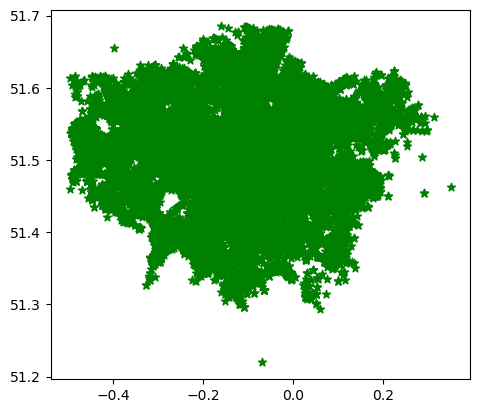

In [21]:
crs_def(gdf_restaurant)

/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_69158/4010438166.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


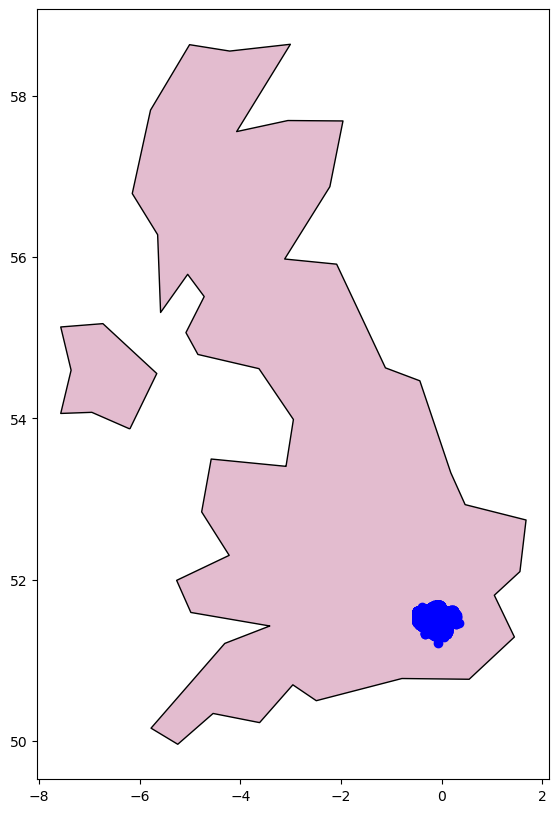

In [22]:
london_map(gdf_restaurant)

### Plotting user data

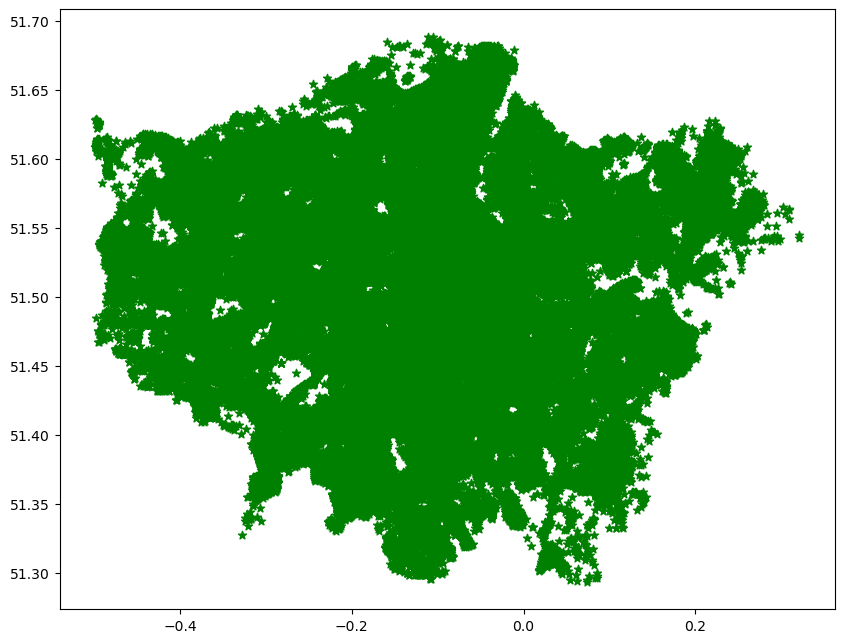

In [23]:
crs_def(gdf_user)

/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_69158/4010438166.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


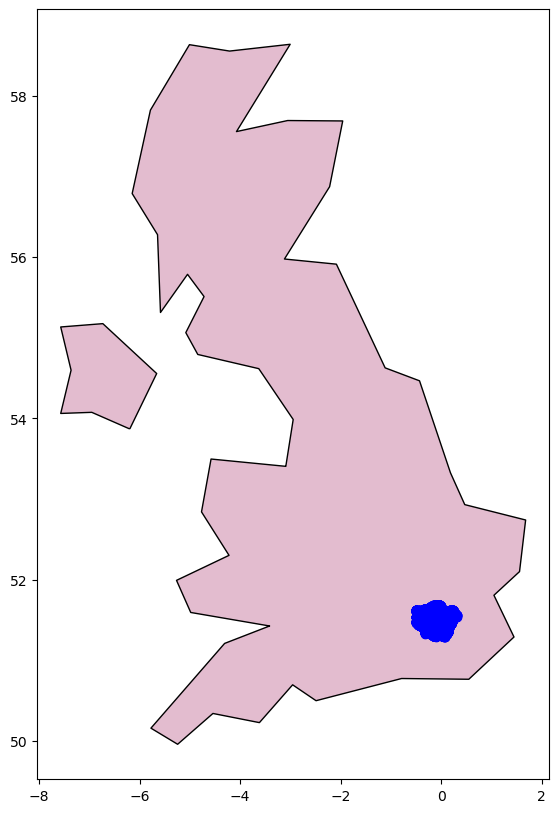

In [24]:
london_map(gdf_user)

In [25]:
london_boundry = london_shapefile()

/Users/kruthikaramesh/opt/anaconda3/envs/newenv/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [26]:
london_boundry

,geometry
0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861..."
2,"POLYGON ((0.01213 51.29960, 0.01196 51.29980, ..."
3,"POLYGON ((-0.24456 51.48870, -0.24468 51.48868..."
4,"POLYGON ((-0.41183 51.53408, -0.41188 51.53412..."
5,"POLYGON ((0.15869 51.51219, 0.15871 51.51224, ..."
6,"POLYGON ((-0.40407 51.61318, -0.40388 51.61229..."
7,"POLYGON ((-0.40407 51.61318, -0.40320 51.61318..."
8,"POLYGON ((-0.19657 51.52765, -0.19685 51.52773..."
9,"POLYGON ((-0.19990 51.67017, -0.19970 51.66986..."


### Overlapping London map with the data imported

#### 1. Restaurant Data

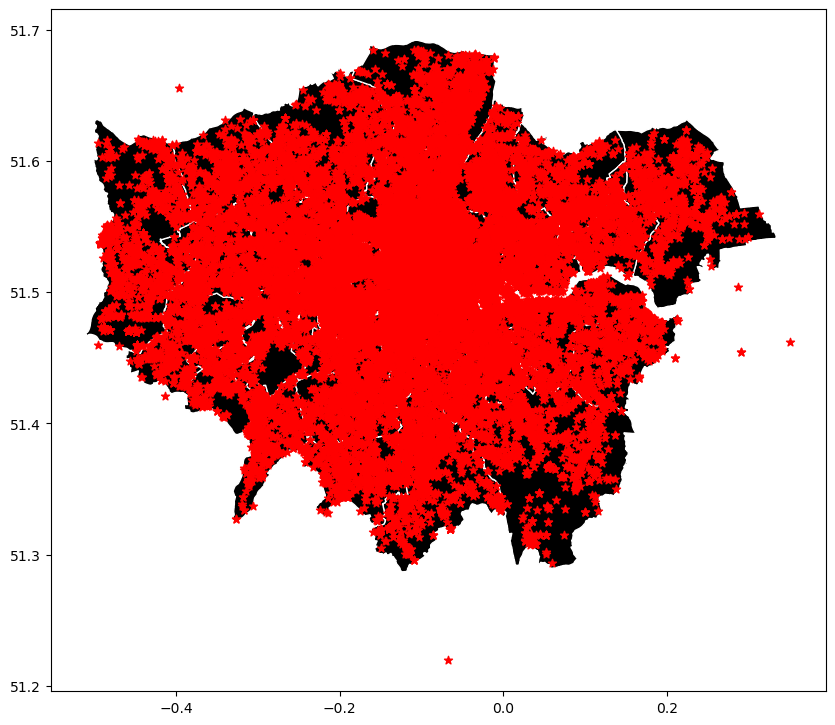

In [27]:
overlap_london(gdf_restaurant,london_boundry)

#### 2. User data

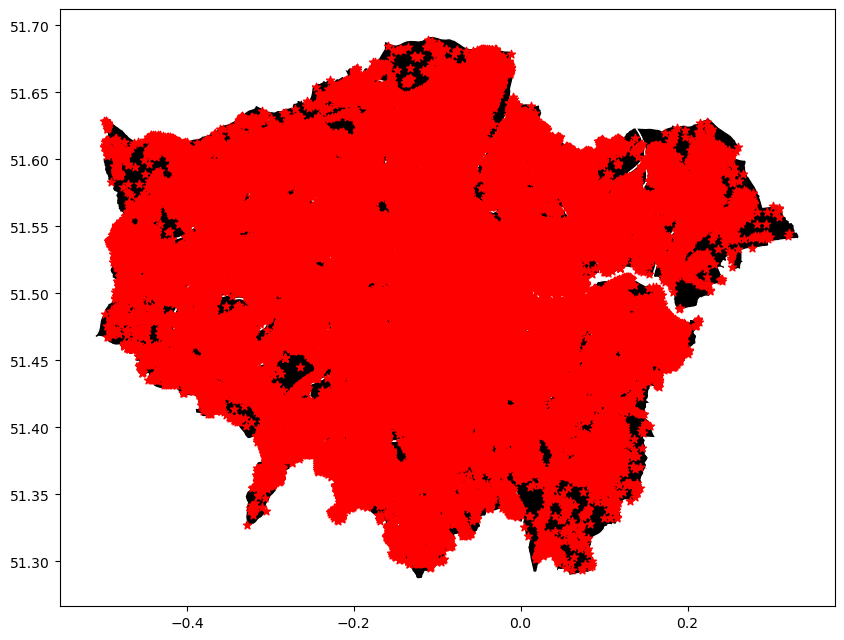

In [28]:
overlap_london(gdf_user,london_boundry)

### Determining the most influential location
Now we need to determine the potential candidate location which is most influential to establish a new restaurant.
This is determined based on the user's location. We consider the nearest location from user to a restaurant (NN - Nearest Neighbour.

1. The entire spatial representation of user is divided into grid cell of the length 0.01.
2. NLC (nearlest location center), the coordinates of the restaurant which is closest to the user and the radius between them is calculated.
3. we try to overlap the NLC radius and the grid cell. The cells with maximum overlapping is the most influential location to establish a restaurant


###  Fast Influential Location Miner (FILM) algorithm 
 Steps for the algorithm is as follows
 1. Compute NLC for each client:For each client in the dataset, we calculate their Neighborhood Location Context (NLC) based on their check-ins. NLC represents the set of grid cells or geographic areas that are relevant to each client.
2. Iterate over clients and grid cells:We iterate over each client in the dataset and, for each client, we consider the grid cells that overlap with their NLC.For example, if a client frequently visits restaurants in a particular area, their NLC would include the grid cells that cover that area.
3. Count check-ins in each grid cell:As we iterate over the clients and grid cells, we increment the counter value for each grid cell that is part of the client's NLC.This step helps us keep track of the number of clients associated with each grid cell.
4. Identify the most influential location:After processing all the clients and grid cells, we determine the grid cell with the highest count from the counter values.This grid cell represents the most influential location or hotspot in the dataset based on the check-in data. It indicates the area where a significant number of clients have checked in, suggesting its influence on user behavior and movement patterns.

### Building KD tree to determine the Reverse nearest neighbour

In [29]:
restaurant_coordinates = coordinates_restaurant_data[['Latitude', 'Longitude']].values
kd_tree = KDTree(restaurant_coordinates)

### Determining the NLC for each User

In [30]:
nlc_radii = []
nlc_value = []
for user_coords in coordinates_user_data[['lat', 'long']].values:
    nearest_restaurant_indices = kd_tree.query(user_coords.reshape(1, -1), k=1)[1][0]
    nearest_restaurant_coords = coordinates_restaurant_data.iloc[nearest_restaurant_indices][['Latitude', 'Longitude']]
    nlc_radius = np.linalg.norm(user_coords - nearest_restaurant_coords.values)
    nlc_radii.append(nlc_radius)
    nlc_value.append(nearest_restaurant_coords.values)

### Calulating grid cell for all users

In [31]:
def calculate_grid_cell(latitude, longitude):
    grid_size = 0.01  # Adjust this value according to your desired grid size
    lat_index = floor(latitude / grid_size)
    lon_index = floor(longitude / grid_size)
    return f"{lat_index},{lon_index}"

# Add a new column 'grid_cell' to coordinates_user_data
coordinates_user_data['grid_cell'] = coordinates_user_data.apply(lambda row: calculate_grid_cell(row['lat'], row['long']), axis=1)


/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_69158/368062737.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates_user_data['grid_cell'] = coordinates_user_data.apply(lambda row: calculate_grid_cell(row['lat'], row['long']), axis=1)


### Overlapping NLC and Grid square and counting all the grids with maximum overlapping

In [32]:
grid_side_length = 0.01  # Adjust this value according to your desired grid size

counter = {}
GRID = set()  # Initialize GRID as an empty set

# Iterate over each user's NLC radii and draw on the grid partitioning
for row, nlc_radius in zip(coordinates_user_data.itertuples(index=False), nlc_radii):
    user_coords = (row.lat, row.long)
    
    # Determine the range of grid cells to check for overlaps
    min_lat = int((user_coords[0] - nlc_radius) // grid_side_length)
    max_lat = int((user_coords[0] + nlc_radius) // grid_side_length)
    min_long = int((user_coords[1] - nlc_radius) // grid_side_length)
    max_long = int((user_coords[1] + nlc_radius) // grid_side_length)

    # Iterate over the grid cells within the range and increment the counter
    for lat in range(min_lat, max_lat + 1):
        for lon in range(min_long, max_long + 1):
            grid_cell = (lat, lon)
            if MINDIST(grid_cell, user_coords, 0.01) <= nlc_radius:
                #checking if each of the cell is already present in the GRID
                if grid_cell in GRID:
                    # if the cell is already present, then increment the existing counter by 1 
                    counter[grid_cell] = counter.get(grid_cell, 0) + 1
                else:
                    #else add the cell to the GRID with initialling it to 1
                    counter[grid_cell] = 1
                    GRID.add(grid_cell)

max_grid_cell = max(counter, key=counter.get)
max_counter_value = counter[max_grid_cell]
print(max_counter_value)


224


#### Counting the most influential location and plotting them on the graph

In [33]:
from collections import Counter

# Create a Counter object from the grid_counter dictionary
counter = Counter(counter)

# Get the top 40 most common grid counter values
top_40 = counter.most_common(40)

# Print the top 20 grid counter values
for grid_cell, count in top_40:
    print(f"Grid Cell: {grid_cell}, Occurrences: {count}")
    latitude = grid_cell[0] * grid_side_length
    longitude = grid_cell[1] * grid_side_length

    
    print("Latitude:", latitude," Longitude:", longitude)

Grid Cell: (5152, -3), Occurrences: 224
Latitude: 51.52  Longitude: -0.03
Grid Cell: (5153, -3), Occurrences: 223
Latitude: 51.53  Longitude: -0.03
Grid Cell: (5152, -4), Occurrences: 222
Latitude: 51.52  Longitude: -0.04
Grid Cell: (5153, -4), Occurrences: 217
Latitude: 51.53  Longitude: -0.04
Grid Cell: (5154, -13), Occurrences: 148
Latitude: 51.54  Longitude: -0.13
Grid Cell: (5155, -13), Occurrences: 148
Latitude: 51.550000000000004  Longitude: -0.13
Grid Cell: (5154, -12), Occurrences: 145
Latitude: 51.54  Longitude: -0.12
Grid Cell: (5155, -12), Occurrences: 141
Latitude: 51.550000000000004  Longitude: -0.12
Grid Cell: (5138, -2), Occurrences: 62
Latitude: 51.38  Longitude: -0.02
Grid Cell: (5157, -40), Occurrences: 61
Latitude: 51.57  Longitude: -0.4
Grid Cell: (5138, -1), Occurrences: 56
Latitude: 51.38  Longitude: -0.01
Grid Cell: (5157, -39), Occurrences: 50
Latitude: 51.57  Longitude: -0.39
Grid Cell: (5130, -11), Occurrences: 47
Latitude: 51.300000000000004  Longitude: -0.1

In [34]:
latitudes = []
longitudes = []

# Iterate over the top 20 grid counter values
for grid_cell, count in top_20:
    # Calculate the latitude and longitude of the grid cell
    latitude = grid_cell[0] * grid_side_length
    longitude = grid_cell[1] * grid_side_length

    # Append the latitude and longitude to the respective lists
    latitudes.append(latitude)
    longitudes.append(longitude)

# Create a DataFrame using the lists
candidate_location = pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes})



In [35]:
gdf_candidate = gpd.GeoDataFrame(candidate_location, geometry= gpd.points_from_xy(candidate_location.Longitude, candidate_location.Latitude))
gdf_candidate


,Latitude,Longitude,geometry
0,51.52,-0.03,POINT (-0.03000 51.52000)
1,51.53,-0.03,POINT (-0.03000 51.53000)
2,51.52,-0.04,POINT (-0.04000 51.52000)
3,51.53,-0.04,POINT (-0.04000 51.53000)
4,51.54,-0.13,POINT (-0.13000 51.54000)
5,51.55,-0.13,POINT (-0.13000 51.55000)
6,51.54,-0.12,POINT (-0.12000 51.54000)
7,51.55,-0.12,POINT (-0.12000 51.55000)
8,51.38,-0.02,POINT (-0.02000 51.38000)
9,51.57,-0.40,POINT (-0.40000 51.57000)


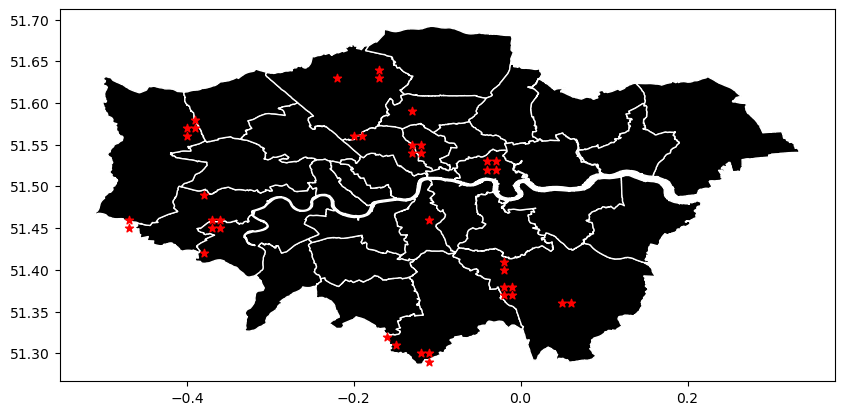

In [36]:
overlap_london(gdf_candidate,london_boundry)

### Maximizing influence using Covering Cell 
#### 1. Sorting the NLC radius in non decreasing order of the radius.

In [37]:
nlc_radii = []
for user_coords in coordinates_user_data[['lat', 'long']].values:
    nearest_restaurant_indices = kd_tree.query(user_coords.reshape(1, -1), k=1)[1][0]
    nearest_restaurant_coords = coordinates_restaurant_data.iloc[nearest_restaurant_indices][['Latitude', 'Longitude']]
    nlc_radius = float(np.linalg.norm(user_coords - nearest_restaurant_coords.values))
    nlc_radii.append(nlc_radius)

# Add NLC radii to coordinates_user_data
coordinates_user_data['nlc_radi'] = nlc_radii

# Sort coordinates_user_data based on NLC radii
sorted_coordinates_user_data = coordinates_user_data.sort_values('nlc_radi')

# Reset index after sorting
sorted_coordinates_user_data.reset_index(drop=True, inplace=True)

# Get sorted NLC radii and user coordinates
sorted_nlc_radii = sorted_coordinates_user_data['nlc_radi'].values
sorted_user_coords = sorted_coordinates_user_data[['lat', 'long']].values


/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_69158/1188585003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates_user_data['nlc_radi'] = nlc_radii


In [38]:
import numpy as np

# Step 1: Calculate NLC radii
nlc_radii = []
nlc_radius = float('inf')  # Initialize with a large value

for user_coords in coordinates_user_data[['lat', 'long']].values:
    nearest_restaurant_indices = kd_tree.query(user_coords.reshape(1, -1), k=1)[1][0]
    nearest_restaurant_coords = coordinates_restaurant_data.iloc[nearest_restaurant_indices][['Latitude', 'Longitude']]
    current_radius = float(np.linalg.norm(user_coords - nearest_restaurant_coords.values))
    
    if current_radius > 0 and current_radius < nlc_radius:
        nlc_radius = current_radius

    nlc_radii.append(current_radius)

# Add NLC radii to coordinates_user_data
coordinates_user_data['nlc_radi'] = nlc_radii

# Sort coordinates_user_data based on NLC radii
sorted_coordinates_user_data = coordinates_user_data.sort_values('nlc_radi')

# Reset index after sorting
sorted_coordinates_user_data.reset_index(drop=True, inplace=True)

# Get sorted NLC radii and user coordinates
sorted_nlc_radii = sorted_coordinates_user_data['nlc_radi'].values
sorted_user_coords = sorted_coordinates_user_data[['lat', 'long']].values


/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_69158/2707356370.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates_user_data['nlc_radi'] = nlc_radii


In [39]:
sorted_coordinates_user_data

,pcds,lat,long,grid_cell,nlc_radi
0,SW8 5AF,51.482165,-0.134422,"5148,-14",0.000000
1,SW8 5AP,51.482165,-0.134422,"5148,-14",0.000000
2,SW11 7DN,51.482165,-0.134422,"5148,-14",0.000000
3,SW8 5AN,51.482165,-0.134422,"5148,-14",0.000000
4,SW11 4LU,51.474155,-0.155038,"5147,-16",0.000000
...,...,...,...,...,...
326209,RM14 3RB,51.543095,0.320763,"5154,32",0.018340
326210,TN14 7NY,51.300229,0.085871,"5130,8",0.018348
326211,TN16 2JD,51.297705,0.085728,"5129,8",0.020336
326212,TN16 2JB,51.296092,0.083360,"5129,8",0.020616


#### 2. Passing the sorted NLC into the grid list based on upper and lower bounds.

In [40]:
def calculate_grid_cell(latitude, longitude, grid_size):
    lat_index = (latitude // grid_size).astype(int)
    lon_index = (longitude // grid_size).astype(int)
    return lat_index, lon_index

In [41]:
delta = 2

##### Allocating all the NLC to their respectvie grid - New code

In [42]:
delta = 2  # Factor to determine the range of grid sizes

# Step 1: Determine epsilon_min
r_min = sorted_nlc_radii[0]
epsilon_min = float(r_min / delta)

# Step 2: Create GList
GList = {}
batch_size = 1000# Define the batch size
for batch_start in range(0, len(sorted_nlc_radii), batch_size):
    batch_end = min(batch_start + batch_size, len(sorted_nlc_radii))
    batch_nlc_radii = sorted_nlc_radii[batch_start:batch_end]
    batch_user_coords = sorted_user_coords[batch_start:batch_end]
    
    for nlc_radius, nlc_coords in zip(batch_nlc_radii, batch_user_coords):
        grid_size = float(delta * epsilon_min)
    
        # Adjust grid_size to a minimum positive value if it is zero
        if grid_size == 0:
            grid_size = 1e-6  # Set a very small positive value

        while nlc_radius > delta * grid_size:
            grid_size *= delta
    
        grid_cell = calculate_grid_cell(nlc_coords[0], nlc_coords[1], grid_size)
        grid_info_key = (grid_cell, grid_size)
    
        if grid_info_key in GList:
            grid_info = GList[grid_info_key]
            grid_info['counter'][grid_cell] = grid_info['counter'].get(grid_cell, 0) + 1
            grid_info['NLCs'].append((nlc_coords, nlc_radius))
        else:
            grid_info = {
                'grid_cell': grid_cell,
                'grid_size': grid_size,
                'counter': {grid_cell: 1},
                'NLCs': [(nlc_coords, nlc_radius)]
            }
            GList[grid_info_key] = grid_info


In [43]:
len(GList)

148372

In [44]:
last_3000_data = list(GList.values())[-3000:]

for data in last_3000_data:
    print(data)


{'grid_cell': (25138, -207), 'grid_size': 0.002048, 'counter': {(25138, -207): 1}, 'NLCs': [(array([51.483145, -0.423015]), 0.003177136603922957)]}
{'grid_cell': (25121, 52), 'grid_size': 0.002048, 'counter': {(25121, 52): 4}, 'NLCs': [(array([51.448429,  0.107213]), 0.0031772427748002845), (array([51.448799,  0.10769 ]), 0.003416419478050927), (array([51.44969 ,  0.108106]), 0.003570026589537726), (array([51.448641,  0.108446]), 0.003685019538618497)]}
{'grid_cell': (25117, -184), 'grid_size': 0.002048, 'counter': {(25117, -184): 5}, 'NLCs': [(array([51.441046, -0.375845]), 0.0031773094923227465), (array([51.440714, -0.375886]), 0.0032515473255061438), (array([51.440309, -0.375835]), 0.003473282166771141), (array([51.441613, -0.375249]), 0.0036531430590662707), (array([51.439766, -0.375552]), 0.003996276718398692)]}
{'grid_cell': (25199, 86), 'grid_size': 0.002048, 'counter': {(25199, 86): 1}, 'NLCs': [(array([51.607775,  0.176252]), 0.003177453225462114)]}
{'grid_cell': (25114, -84),

{'grid_cell': (12592, -54), 'grid_size': 0.004096, 'counter': {(12592, -54): 6}, 'NLCs': [(array([51.577899, -0.217831]), 0.004108039556771799), (array([51.577322, -0.217709]), 0.004122343265668586), (array([51.579493, -0.218335]), 0.0041269536077947816), (array([51.577578, -0.218973]), 0.004167153104944132), (array([51.577644, -0.219129]), 0.004229106406797907), (array([51.578629, -0.219693]), 0.004630382446406804)]}
{'grid_cell': (12547, 1), 'grid_size': 0.004096, 'counter': {(12547, 1): 5}, 'NLCs': [(array([5.1395591e+01, 7.6060000e-03]), 0.0041080956658763905), (array([5.1394279e+01, 7.0740000e-03]), 0.004543592631390597), (array([5.1393497e+01, 7.0540000e-03]), 0.004765897292221766), (array([5.1394863e+01, 8.1630000e-03]), 0.004970911083493917), (array([5.1394288e+01, 8.0930000e-03]), 0.0052658420029457805)]}
{'grid_cell': (12542, -10), 'grid_size': 0.004096, 'counter': {(12542, -10): 4}, 'NLCs': [(array([ 5.1375498e+01, -4.0001000e-02]), 0.004108129021160773), (array([ 5.1373231e

{'grid_cell': (12560, -57), 'grid_size': 0.004096, 'counter': {(12560, -57): 24}, 'NLCs': [(array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.447121, -0.233217]), 0.004698488545266104), (array([51.446876, -0.232421]), 0.005528154792513947), (array([51.448371, -0.232017]), 0.0055667858419379025), (array([51.44722, -0.23199]), 0.005820937657285233), (array([51.449358, -0.230646]), 0.005855668669759156), (array([51.447966, -0.2314  ]), 0.006230261086824679), (array([51.448038, -0.231383])

In [45]:
grid_sizes = set(grid_info['grid_size'] for grid_info in GList.values())

for size in grid_sizes:
    print(size)


0.000512
0.001024
0.016384
6.4e-05
8e-06
0.002048
0.000256
2e-06
0.008192
4e-06
3.2e-05
0.000128
0.004096
1.6e-05
1e-06


In [46]:
top_20 = sorted(GList.values(), key=lambda x: max(x['counter'].values()), reverse=True)[:20]

for i, grid_info in enumerate(top_20, 1):
    grid_cell = grid_info['grid_cell']
    grid_size = grid_info['grid_size']
    counter = max(grid_info['counter'].values())
    print(f"Top {i}: Grid Cell: {grid_cell}, Grid Size: {grid_size}, Counter: {counter}")


Top 1: Grid Cell: (201238, -525), Grid Size: 0.000256, Counter: 2107
Top 2: Grid Cell: (50323, -133), Grid Size: 0.001024, Counter: 2055
Top 3: Grid Cell: (6436595, -10020), Grid Size: 8e-06, Counter: 1798
Top 4: Grid Cell: (805071, -1751), Grid Size: 6.4e-05, Counter: 1687
Top 5: Grid Cell: (51524503, -112088), Grid Size: 1e-06, Counter: 1573
Top 6: Grid Cell: (402797, 565), Grid Size: 0.000128, Counter: 1384
Top 7: Grid Cell: (25188, -161), Grid Size: 0.002048, Counter: 1364
Top 8: Grid Cell: (200686, -359), Grid Size: 0.000256, Counter: 1310
Top 9: Grid Cell: (50199, -286), Grid Size: 0.001024, Counter: 979
Top 10: Grid Cell: (100691, -340), Grid Size: 0.000512, Counter: 942
Top 11: Grid Cell: (100882, -151), Grid Size: 0.000512, Counter: 926
Top 12: Grid Cell: (6426028, 2197), Grid Size: 8e-06, Counter: 915
Top 13: Grid Cell: (402648, -808), Grid Size: 0.000128, Counter: 847
Top 14: Grid Cell: (201505, -71), Grid Size: 0.000256, Counter: 840
Top 15: Grid Cell: (100578, -269), Grid 

In [47]:
GList

{((51482165, -134423), 1e-06): {'grid_cell': (51482165, -134423),
  'grid_size': 1e-06,
  'counter': {(51482165, -134423): 13},
  'NLCs': [(array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0)]},
 ((51474155, -155039), 1e-06): {'grid_cell': (51474155, -155039),
  'grid_size': 1e-06,
  'counter': {(51474155, -155039): 1},
  'NLCs': [(array([51.474155, -0.155038]), 0.0)]},
 ((51634101, -6362), 1e-06): {'grid_cell': (51634101, -6362),
  'grid_size': 1e-06,
  'counter': {(51634101, -6362): 1},
  'NLCs': [(array([ 5.1634101e

In [48]:
def calculate_covering_cell(latitude,longitude, higher_grid_size):
    i = (latitude // (higher_grid_size))
    j = (longitude //(higher_grid_size))
    return (i, j)

#### 4. Calculating influence value of the covering cell. 

In [49]:
import numpy as np

epsilon = 1e-9  # Small non-zero value
min_grid_size = 1e-9  # Minimum grid size threshold

grid_cells, grid_sizes = zip(*GList.keys())  # Extract grid cells and grid sizes separately
grid_cell_array = np.array(grid_cells)  # Convert grid cells to a NumPy array
grid_size_array = np.array(grid_sizes)  # Convert grid sizes to a NumPy array
influence_values = np.zeros(len(grid_cell_array), dtype=int)  # Use a NumPy array to store influence values

batch_size = 1000  # Define the batch size
num_batches = len(grid_cell_array) // batch_size + 1

for batch_idx in range(num_batches):
    batch_start = batch_idx * batch_size
    batch_end = min(batch_start + batch_size, len(grid_cell_array))
    batch_grid_cells = grid_cell_array[batch_start:batch_end]
    batch_grid_sizes = grid_size_array[batch_start:batch_end]
    batch_influence_values = influence_values[batch_start:batch_end]

    for i, grid_cell in enumerate(batch_grid_cells):
        grid_size = batch_grid_sizes[i]
        higher_grid_size = delta * max(grid_size, min_grid_size)  # Adjusted higher grid size
        grid_info_key = tuple(grid_cell), grid_size
        grid_info = GList[grid_info_key]  # Store grid info in a variable
        influence_value = grid_info['counter'].get(tuple(grid_cell), 0) + 1  # Initial influence value
        x, y = (grid_cell[0] + 0.5) * grid_size, (grid_cell[1] + 0.5) * grid_size

        covering_cells_set = set(grid_info['counter'].keys())  # Convert keys to a set for faster lookup
        for j, higher_grid_cell in enumerate(batch_grid_cells):
            if abs(batch_grid_sizes[j] - higher_grid_size) < epsilon:
                higher_grid_info_key = tuple(higher_grid_cell), batch_grid_sizes[j]
                higher_grid_info = GList[higher_grid_info_key]
                covering_cell = calculate_covering_cell(x, y, higher_grid_size)
                if covering_cell in covering_cells_set:
                    influence_value += higher_grid_info['counter'][tuple(covering_cell)]

        GList[grid_info_key]["influence_value"] = influence_value
        batch_influence_values[i] = influence_value

    influence_values[batch_start:batch_end] = batch_influence_values


In [50]:
GList

{((51482165, -134423), 1e-06): {'grid_cell': (51482165, -134423),
  'grid_size': 1e-06,
  'counter': {(51482165, -134423): 13},
  'NLCs': [(array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0),
   (array([51.482165, -0.134422]), 0.0)],
  'influence_value': 14},
 ((51474155, -155039), 1e-06): {'grid_cell': (51474155, -155039),
  'grid_size': 1e-06,
  'counter': {(51474155, -155039): 1},
  'NLCs': [(array([51.474155, -0.155038]), 0.0)],
  'influence_value': 2},
 ((51634101, -6362), 1e-06): {'grid_cell': (51634101, -6362),
  'grid_size': 1e-06,
  'counter': {(516

In [51]:
# Sort the grid cells based on influence value in descending order
sorted_grid_cells = sorted(GList.keys(), key=lambda x: GList[x]['influence_value'], reverse=True)

# Print the top 20 grid cells
top_40_grid_cells = sorted_grid_cells[:40]
for grid_cell in top_40_grid_cells:
    print("Grid Cell:", grid_cell)
    print("Influence Value:", GList[grid_cell]['influence_value'])
    print()


Grid Cell: ((201238, -525), 0.000256)
Influence Value: 2108

Grid Cell: ((50323, -133), 0.001024)
Influence Value: 2056

Grid Cell: ((6436595, -10020), 8e-06)
Influence Value: 1799

Grid Cell: ((805071, -1751), 6.4e-05)
Influence Value: 1688

Grid Cell: ((51524503, -112088), 1e-06)
Influence Value: 1574

Grid Cell: ((402797, 565), 0.000128)
Influence Value: 1385

Grid Cell: ((25188, -161), 0.002048)
Influence Value: 1365

Grid Cell: ((200686, -359), 0.000256)
Influence Value: 1311

Grid Cell: ((50199, -286), 0.001024)
Influence Value: 980

Grid Cell: ((100691, -340), 0.000512)
Influence Value: 943

Grid Cell: ((100882, -151), 0.000512)
Influence Value: 927

Grid Cell: ((6426028, 2197), 8e-06)
Influence Value: 916

Grid Cell: ((402648, -808), 0.000128)
Influence Value: 848

Grid Cell: ((201505, -71), 0.000256)
Influence Value: 841

Grid Cell: ((100578, -269), 0.000512)
Influence Value: 803

Grid Cell: ((100527, -706), 0.000512)
Influence Value: 794

Grid Cell: ((100611, -56), 0.000512)


In [52]:
import pandas as pd

# Create an empty list to store the coordinates
coordinates = []

# Extract the coordinates from the top 20 grid cells in the GList
for grid_info_key in top_40_grid_cells:
    grid_cell = grid_info_key[0]
    grid_size = grid_info_key[1]
    latitude = (grid_cell[0] + 0.5) * grid_size
    longitude = (grid_cell[1] + 0.5) * grid_size
    coordinates.append({'Latitude': latitude, 'Longitude': longitude})

# Create a DataFrame from the list of coordinates
coordinates_df = pd.DataFrame(coordinates)

# Print the resulting DataFrame
print(coordinates_df)



     Latitude  Longitude
0   51.517056  -0.134272
1   51.531264  -0.135680
2   51.492764  -0.080156
3   51.524576  -0.112032
4   51.524503  -0.112087
5   51.558080   0.072384
6   51.586048  -0.328704
7   51.375744  -0.091776
8   51.404288  -0.292352
9   51.554048  -0.173824
10  51.651840  -0.077056
11  51.408228   0.017580
12  51.539008  -0.103360
13  51.585408  -0.018048
14  51.496192  -0.137472
15  51.470080  -0.361216
16  51.513088  -0.028416
17  51.416576  -0.213504
18  51.532544  -0.060672
19  51.514112  -0.321792
20  51.516288  -0.175232
21  51.510784  -0.220672
22  51.642880  -0.171520
23  51.516352  -0.123712
24  51.510016  -0.307456
25  51.519028  -0.058076
26  51.534080  -0.248064
27  51.562176  -0.213312
28  51.491532  -0.262588
29  51.550720  -0.307712
30  51.431168  -0.130816
31  51.503872  -0.414464
32  51.463680  -0.304640
33  51.537332  -0.487340
34  51.570248   0.170632
35  51.613440  -0.277760
36  51.500488  -0.276984
37  51.464448  -0.164608
38  51.546772  -0.370916


In [53]:
coordinates_df.to_csv('London Population /Candidate_location.csv')

In [54]:
gdf_influential_candidate = gpd.GeoDataFrame(coordinates_df, geometry= gpd.points_from_xy(coordinates_df.Longitude, coordinates_df.Latitude))
gdf_influential_candidate

,Latitude,Longitude,geometry
0,51.517056,-0.134272,POINT (-0.13427 51.51706)
1,51.531264,-0.135680,POINT (-0.13568 51.53126)
2,51.492764,-0.080156,POINT (-0.08016 51.49276)
3,51.524576,-0.112032,POINT (-0.11203 51.52458)
4,51.524503,-0.112087,POINT (-0.11209 51.52450)
5,51.558080,0.072384,POINT (0.07238 51.55808)
6,51.586048,-0.328704,POINT (-0.32870 51.58605)
7,51.375744,-0.091776,POINT (-0.09178 51.37574)
8,51.404288,-0.292352,POINT (-0.29235 51.40429)
9,51.554048,-0.173824,POINT (-0.17382 51.55405)


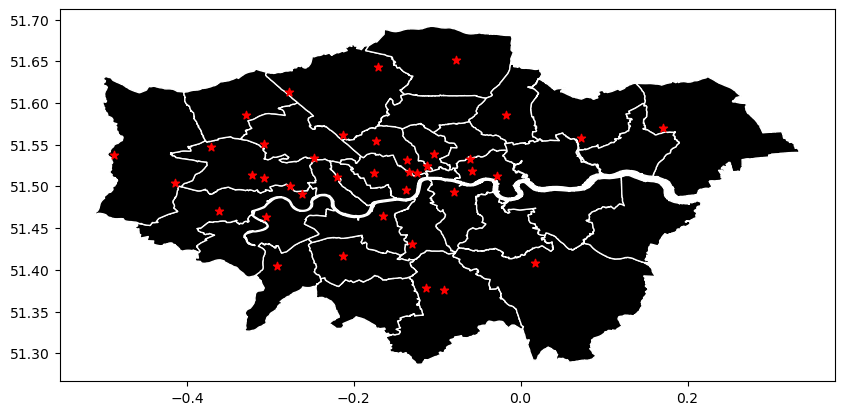

In [55]:
overlap_london(gdf_influential_candidate,london_boundry)

## Word2Vec Algorithm 

### Importing important libraries

In [11]:
!pip install gensim


In [13]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Reading the Dataset

#### To fill all the missing cuisine, Word2Vec uses Yelp Dataset.

In [14]:
yelp_cuisine = pd.read_csv("London Population /yelp_academic_dataset_business.csv")

In [15]:
yelp_cuisine

,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.4266787,-119.7111968,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists",Unnamed: 13
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
4,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150340,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150341,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150342,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",NaN
150343,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': ""{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


In [16]:
recom_restaurant = pd.read_csv("Cleaned_category_restaurant.csv")

In [17]:
recom_restaurant

,Unnamed: 0.1,Unnamed: 0,Address,Business Name,Business Type,BusinessTypeID,FHRSID,Latitude,Longitude,Local Authority BusinessID,...,New Rating Pending,Post Code,Rating Key,Rating Value,Scheme Type,Confidence In Management,Hygiene,Structural,/Header/ItemCount/#agg,category_restaurant
0,1,1,Rio Cinema Dalston 103-107 Kingsland High Stre...,"""Rio Cinema""",Restaurant/Cafe/Canteen,1.0,468824.0,51.549539,-0.075568,1317,...,False,E8 2PB,fhrs_3_en-GB,3,FHRS,10.0,10.0,10.0,NaN,True
1,3,3,Basement To Ground Floor 33 Broadway Market Ha...,%Arabica,Other catering premises,7841.0,1225476.0,51.536510,-0.062051,130435,...,False,E8 4PH,fhrs_5_en-GB,5,FHRS,5.0,5.0,5.0,NaN,True
2,4,4,45-47 lower Clapton road Hackney London,&organic ltd,Restaurant/Cafe/Canteen,1.0,1527059.0,51.550962,-0.052203,HAC1459,...,False,E50NS,fhrs_awaitinginspection_en-GB,AwaitingInspection,FHRS,NaN,NaN,NaN,NaN,True
3,6,6,485 kingsland road Hackney London,@las coffee house,Restaurant/Cafe/Canteen,1.0,1578908.0,51.544256,-0.076300,HAC1551,...,False,E84AU,fhrs_4_en-GB,4,FHRS,5.0,5.0,10.0,NaN,True
4,7,7,100-102 Hoxton Street Hackney London,100 Hoxton,Restaurant/Cafe/Canteen,1.0,470180.0,51.531025,-0.079986,33623,...,False,N1 6SG,fhrs_5_en-GB,5,FHRS,5.0,5.0,5.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42564,78778,78778,2 Castle Street Kingston Upon Thames,Yoriya,Takeaway/sandwich shop,7844.0,1385803.0,51.411049,-0.301725,21/00085/COM,...,False,KT1 1SS,fhrs_1_en-GB,1,FHRS,20.0,15.0,10.0,NaN,True
42565,78779,78779,96 Burlington Road New Malden,You Me Korean Restaurant,Restaurant/Cafe/Canteen,1.0,1386083.0,51.398814,-0.249460,21/10939/RBK,...,False,KT3 4NT,fhrs_3_en-GB,3,FHRS,10.0,10.0,10.0,NaN,True
42566,78781,78781,43 Market Place Kingston Upon Thames,Zizzi And Coco Di Mama,Restaurant/Cafe/Canteen,1.0,1386687.0,51.408839,-0.306178,21/97574/RBK,...,False,KT1 1ET,fhrs_5_en-GB,5,FHRS,5.0,5.0,5.0,NaN,True
42567,78782,78782,Kings Oak Primary School Dickerage Lane New Ma...,Zone All Sports And Care At Kings Oak Primary ...,School/college/university,7845.0,1594642.0,51.404842,-0.274529,23/00055/COM,...,False,KT3 3RZ,fhrs_5_en-GB,5,FHRS,5.0,5.0,0.0,NaN,True


In [18]:
column_names = ['ID','Name','Address','City','State','PostalCode','Latitude','Longitude','Stars','Review','IsOpen','Attributes','Cusines','Timmings']

In [19]:
yelp_cuisine.columns = column_names
yelp_cuisine = yelp_cuisine.dropna()

In [20]:
# Define the batch size for processing
batch_size = 1000

# Load the training dataset
train_data = pd.read_csv('yelp_cuisine.csv')

# Preprocess the text data
def preprocess_text(row):
    business_name = row['Name']
    cuisine_type = row['Cusines']
    text = ' '.join([business_name, cuisine_type])
    return text.lower().split()

train_data['processed_text'] = train_data.apply(preprocess_text, axis=1)

# Initialize an empty Word2Vec model
model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)

# Prepare the text data for training
sentences = train_data['processed_text'].tolist()

# Build vocabulary and train the Word2Vec model
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

# Load the recommendation dataset
recommendation_data = pd.read_csv('Cleaned_category_restaurant.csv')

def preprocess_recommendation(row):
    business_name = row['Business Name ']
    if pd.isna(business_name):
        return ''
    else:
        return business_name.lower().strip('"').split()

recommendation_data['processed_text'] = recommendation_data.apply(preprocess_recommendation, axis=1)

# Process the recommendation data in batches
num_batches = len(recommendation_data) // batch_size

predictions = []
for i in range(num_batches):
    # Get the current batch of data
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch_data = recommendation_data.iloc[start_idx:end_idx]
    

    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the training data
    train_tfidf = vectorizer.fit_transform(train_data['processed_text'].apply(' '.join))

    # Transform the recommendation data
    recommendation_tfidf = vectorizer.transform(batch_data['processed_text'].apply(' '.join))

    # Calculate similarity using cosine similarity
    similarity_scores = cosine_similarity(recommendation_tfidf, train_tfidf)

    # Find the most similar training data index for each recommendation in the batch
    most_similar_indices = similarity_scores.argmax(axis=1)
    
    # Get the predicted cuisine type for each recommendation in the batch
    predicted_cuisine_types = train_data.iloc[most_similar_indices]['Cusines'].tolist()
    predictions.extend(predicted_cuisine_types)

# Process the remaining data (last batch)
start_idx = num_batches * batch_size
batch_data = recommendation_data.iloc[start_idx:]


# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
train_tfidf = vectorizer.fit_transform(train_data['processed_text'].apply(' '.join))

# Transform the recommendation data
recommendation_tfidf = vectorizer.transform(batch_data['processed_text'].apply(' '.join))

# Calculate similarity using cosine similarity
similarity_scores = cosine_similarity(recommendation_tfidf, train_tfidf)

# Find the most similar training data index for each recommendation in the last batch
most_similar_indices = similarity_scores.argmax(axis=1)

# Get the predicted cuisine type for each recommendation in the last batch
predicted_cuisine_types = train_data.iloc[most_similar_indices]['Cusines'].tolist()
predictions.extend(predicted_cuisine_types)

# Add the predicted cuisine types as a new column in the recommendation dataset
recommendation_data['Predicted Cuisine Type'] = predictions

# Save the recommendation dataset with the predicted cuisine types
recommendation_data.to_csv('recommended_dataset_with_cuisine.csv', index=False)


In [21]:
recommendation_cuisine = recommendation_data[['Business Name ','Business Type','Latitude','Longitude','Predicted Cuisine Type']]

In [22]:
recommendation_cuisine

,Business Name,Business Type,Latitude,Longitude,Predicted Cuisine Type
0,"""Rio Cinema""",Restaurant/Cafe/Canteen,51.549539,-0.075568,"Latin American, Restaurants"
1,%Arabica,Other catering premises,51.536510,-0.062051,"Hookah Bars, Greek, Restaurants, Food, Juice B..."
2,&organic ltd,Restaurant/Cafe/Canteen,51.550962,-0.052203,"Antiques, Shopping, Furniture Stores, Home & G..."
3,@las coffee house,Restaurant/Cafe/Canteen,51.544256,-0.076300,"Coffee & Tea, Food"
4,100 Hoxton,Restaurant/Cafe/Canteen,51.531025,-0.079986,"Nail Salons, Beauty & Spas"
...,...,...,...,...,...
42564,Yoriya,Takeaway/sandwich shop,51.411049,-0.301725,"Shipping Centers, Local Services, Notaries, Ma..."
42565,You Me Korean Restaurant,Restaurant/Cafe/Canteen,51.398814,-0.249460,"Beauty & Spas, Hair Salons"
42566,Zizzi And Coco Di Mama,Restaurant/Cafe/Canteen,51.408839,-0.306178,"Restaurants, Breakfast & Brunch, American (Tra..."
42567,Zone All Sports And Care At Kings Oak Primary ...,School/college/university,51.404842,-0.274529,"American (New), Bars, Restaurants, Nightlife"


## Recommendation System for the candidate location

### Importing Libraries

In [63]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import haversine_distances
from math import radians

### Data Preprocessing 
Here we are trying to get information about all restaurant(location, ratings, structure and so on).
we are trying to combine user location with average population for that region and their mean salary.

### 1. Restaurant Data

In [26]:
nonnulll_raw_restaurant_data = recom_restaurant.dropna(subset=['Latitude','Longitude'])

In [61]:
candidate_locations = pd.read_csv("London Population /Candidate_location.csv")

In [27]:
nonnulll_raw_restaurant_data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',5)

In [28]:
nonnulll_raw_restaurant_data

,Unnamed: 0.1,Unnamed: 0,Address,Business Name,Business Type,BusinessTypeID,FHRSID,Latitude,Longitude,Local Authority BusinessID,Local Authority Code,Local Authority Email Address,Local Authority Name,Local Authority WebSite,New Rating Pending,Post Code,Rating Key,Rating Value,Scheme Type,Confidence In Management,Hygiene,Structural,/Header/ItemCount/#agg,category_restaurant
0,1,1,Rio Cinema Dalston 103-107 Kingsland High Stre...,"""Rio Cinema""",Restaurant/Cafe/Canteen,1.0,468824.0,51.549539,-0.075568,1317,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,https://hackney.gov.uk/environmental-health#food,False,E8 2PB,fhrs_3_en-GB,3,FHRS,10.0,10.0,10.0,NaN,True
1,3,3,Basement To Ground Floor 33 Broadway Market Ha...,%Arabica,Other catering premises,7841.0,1225476.0,51.536510,-0.062051,130435,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,https://hackney.gov.uk/environmental-health#food,False,E8 4PH,fhrs_5_en-GB,5,FHRS,5.0,5.0,5.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42567,78782,78782,Kings Oak Primary School Dickerage Lane New Ma...,Zone All Sports And Care At Kings Oak Primary ...,School/college/university,7845.0,1594642.0,51.404842,-0.274529,23/00055/COM,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,http://www.kingston.gov.uk,False,KT3 3RZ,fhrs_5_en-GB,5,FHRS,5.0,5.0,0.0,NaN,True
42568,78784,78784,Malden Parochial C Of E Primary School The Man...,Zone All Sports And Care At Malden Parochial S...,School/college/university,7845.0,1594647.0,51.381095,-0.257782,23/00063/COM,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,http://www.kingston.gov.uk,True,KT4 7LW,fhrs_awaitinginspection_en-GB,AwaitingInspection,FHRS,NaN,NaN,NaN,NaN,True


In [29]:
nonnulll_raw_restaurant_data['Business Type'].unique()

array(['Restaurant/Cafe/Canteen', 'Other catering premises',
       'Mobile caterer', 'Takeaway/sandwich shop', 'Pub/bar/nightclub',
       'School/college/university', 'Hotel/bed & breakfast/guest house',
       'Farmers/growers'], dtype=object)

In [33]:
print(f'Before deletion of rows: {len(nonnulll_raw_restaurant_data)}')
rest_del = boundary_check(nonnulll_raw_restaurant_data,'Longitude','Latitude')
nonnulll_raw_restaurant_data = nonnulll_raw_restaurant_data.drop(index=rest_del)
print(f'After deletion of rows: {len(nonnulll_raw_restaurant_data)}')

Before deletion of rows: 42569
After deletion of rows: 42569


In [34]:
# Define the string values
string_values = ['restaurant', 'Pub', 'Catering', 'Hotel','caterer','Takeaway','Farmers/growers','university']
# Create a new column
nonnulll_raw_restaurant_data['category_restaurant'] = nonnulll_raw_restaurant_data['Business Type'].str.contains('|'.join(string_values), case=False)

In [35]:
cuisine_restaurants = pd.read_csv("Final_combining_Restaurants .csv")

In [36]:
cuisine_restaurants

,Unnamed: 0,Business Name,Business Type,Rating Value,Hygiene,processed_text,Predicted Cuisine Type,Latitude,Longitude,Address
0,0,& Juice Corner,Other catering premises,4,5.0,"['', '&', 'juice', 'corner']",American New,51.522003,-0.418485,906 Uxbridge Road Hayes
1,1,& Mood by Bahar,Restaurant/Cafe/Canteen,5,5.0,"['', '&', 'mood', 'by', 'bahar']",Bakeries Desserts Cafes,51.484206,-0.176735,372 King's Road LONDON
...,...,...,...,...,...,...,...,...,...,...
39272,103187,yz21,Restaurant/Cafe/Canteen,4,10.0,['yz21'],Pan British,51.489920,0.121862,513 Abbey Road London
39273,103188,NaN,Takeaway/sandwich shop,AwaitingInspection,NaN,NaN,Pan British,51.523309,-0.082171,37 Scrutton Street Hackney London


#### Importing Data after predicting and processing the cuisine type for restaurant.

In [38]:
# Merge the two datasets based on 'Latitude' and 'Longitude', and keep only the desired column from the second dataset
merged_final_rest = cuisine_restaurants.merge(nonnulll_raw_restaurant_data[['Latitude', 'Longitude', 'Post Code']], on=['Latitude', 'Longitude'], how='inner')
merged_final_rest = merged_final_rest.drop_duplicates(subset=['Address '], keep='first')


##### Loading Postcode data with OSLAUA to determine number of restaurants for each region

In [39]:
london_postcode = pd.read_csv('London Population /london_postcodes-ons-postcodes-directory-feb22.csv')
postcode_olsua = london_postcode[['pcds','oslaua']]

In [41]:
merged_rest_postcode = pd.merge(merged_final_rest, postcode_olsua, left_on='Post Code', right_on='pcds', how='inner')


In [42]:
nonna_merged_rest_postcode = merged_rest_postcode.dropna(subset = ['Latitude'])

In [43]:
nonna_merged_rest_postcode['Rating Value'].unique()

array(['4', '5', 'AwaitingInspection', '3', '1', '2', '0', 'Exempt',
       'AwaitingPublication'], dtype=object)

In [44]:
nonna_merged_rest_postcode['Hygiene'].unique()

array([ 5.,  0., nan, 10., 15., 20., 25.])

### Data Preprocessing

We have noticed Rating value and hyginee columns containing NAN and Awaiting inspection values. For these rows we will perform numerical imputation using regression to predict the rating values based on the location. This is done instead of deleting the rows to prevent data loss. Imptuing with mean i not condisered as it can introduce bias. 

In [54]:
# Select the 'Rating Value' column
rating_col = nonna_merged_rest_postcode['Rating Value']

# Create a mask for rows with missing values
missing_mask = rating_col.eq('AwaitingPublication') | rating_col.eq('AwaitingInspection') | rating_col.eq('Exempt')

# Create a copy of the 'Rating Value' column for imputation
rating_imputed = rating_col.copy()

# Map the string values to NaN
rating_imputed[missing_mask] = np.nan

# Convert the 'Rating Value' column to float type
rating_imputed = rating_imputed.astype(float)

# Creating a regression imputer
imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)

# Fit and transform the 'Rating Value' column with missing values
rating_imputed = imputer.fit_transform(rating_imputed.values.reshape(-1, 1))

# Flatten the imputed values
rating_imputed = rating_imputed.flatten()

# Assign the imputed values back to the original DataFrame
nonna_merged_rest_postcode.loc[missing_mask, 'Rating Value'] = rating_imputed[:missing_mask.sum()]

# Save the modified DataFrame to a CSV file
nonna_merged_rest_postcode.to_csv('new_rating_imputed_data.csv', index=False)


In [56]:
nonna_merged_rest_postcode['Rating Value'].unique()

array(['4', '5', 4.0, 5.0, '3', '1', 4.384639103013314, '2', '0', 3.0,
       1.0, 2.0, 0.0], dtype=object)

### Location Based Recommendation System

In [57]:
popular_cuisine_types = [
    'Pizza', 'Pan Restaurant', 'Chinese',
    'Cafe', 'American New', 'Coffee Tea Caf', 'Indian', 'Pan Restaurant British',
    'Sandwiches', 'Bar, British, Pub', 'Breakfast Brunch Sandwiches',
    'Italian', 'Mexican', 'American Traditional', 'Fish Chips', 'Caribbean',
    'Cafe, British', 'Bakeries', 'Nightlife Bars', 'Sea', 'Fast food', 'European',
    'Cafes', 'Coffee Tea', 'British', 'Thai', 'Italian Pizza', 'Diners', 'Vietnamese', 'Sushi Bars', 'Burgers', 'Chicken Wings Fast', 'Indian Kebab'
]

# Find existing restaurants where 'predicted cuisine type' matches any of the popular cuisine types
matching_restaurants = nonna_merged_rest_postcode[nonna_merged_rest_postcode['Predicted Cuisine Type'].apply(lambda cuisines: any(cuisine in cuisines for cuisine in popular_cuisine_types))]


In [64]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    distances = haversine_distances(np.array([[lat1, lon1], [lat2, lon2]]))

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Calculate the distance
    distance = distances[0, 1] * radius
    return distance


# Create an empty list to store the results
results = []

# Loop through each candidate location and calculate the distance from each restaurant
for _, candidate_location in candidate_locations.iterrows():
    candidate_latitude = candidate_location['Latitude']
    candidate_longitude = candidate_location['Longitude']

    # Calculate the distance for each restaurant to the current candidate location
    for _, restaurant in matching_restaurants.iterrows():
        restaurant_latitude = restaurant['Latitude']
        restaurant_longitude = restaurant['Longitude']
        restaurant_name = restaurant['Business Name ']
        distance = calculate_distance(candidate_latitude, candidate_longitude, restaurant_latitude, restaurant_longitude)

        # Append the result to the list
        results.append({
            'Candidate Latitude': candidate_latitude,
            'Candidate Longitude': candidate_longitude,
            'Restaurant Name': restaurant_name,
            'Restaurant Cuisine Type': restaurant['Predicted Cuisine Type'],
            'Restaurant Latitude': restaurant_latitude,
            'Restaurant Longitude': restaurant_longitude,
            'Distance': distance
        })

# Create a DataFrame from the results list
distance_df = pd.DataFrame(results)


In [65]:

# Group the rows by Candidate Latitude and Candidate Longitude
grouped_data =distance_df.groupby(['Candidate Latitude', 'Candidate Longitude'])

# Sort the distances within each group in descending order
sorted_data = grouped_data.apply(lambda x: x.sort_values(by='Distance', ascending=True))

# Reset the index of the sorted data
sorted_data.reset_index(drop=True, inplace=True)

# Display the sorted data
print(sorted_data)


         Candidate Latitude  Candidate Longitude  \
0                 51.375744            -0.091776   
1                 51.375744            -0.091776   
...                     ...                  ...   
1216478           51.651840            -0.077056   
1216479           51.651840            -0.077056   

                       Restaurant Name Restaurant Cuisine Type  \
0                      Porter & Sorter          Nightlife Bars   
1                           AMT Coffee          Coffee Tea Caf   
...                                ...                     ...   
1216478  Shampan At The Spinning Wheel             Pan British   
1216479                           Snog             Pan British   

         Restaurant Latitude  Restaurant Longitude   Distance  
0                  51.375996             -0.091879   0.028880  
1                  51.374989             -0.092898   0.114547  
...                      ...                   ...        ...  
1216478            51.293195      

In [67]:
# Group the data by candidate latitude and longitude
grouped_data = sorted_data.groupby(['Candidate Latitude', 'Candidate Longitude'])

# Define a function to get the top 10 restaurants for each group
def get_top_30_restaurants(group):
    return group.nsmallest(30, 'Distance')

# Apply the function to each group and concatenate the results
top_30_restaurants = grouped_data.apply(get_top_30_restaurants).reset_index(drop=True)

### Context Aware Recommendation System

In [69]:
# Group by the 'Restaurant Cuisine Type' column and count the occurrences
cuisine_type_counts =sorted_data.groupby('Restaurant Cuisine Type').size().reset_index(name='Count')

# Sort the counts in descending order
cuisine_type_counts = cuisine_type_counts.sort_values(by='Count', ascending=False)

In [70]:
# Group the data by Candidate Latitude and Candidate Longitude
grouped_data = sorted_data.groupby(['Candidate Latitude', 'Candidate Longitude'])

# Find the index of restaurants with the minimum distance for each group (Candidate Latitude and Longitude)
restaurants_with_min_distance_index = grouped_data.apply(lambda x: x.nsmallest(30, 'Distance').index.tolist())

# Create an empty list to store the result
result_data = []

# Loop through each group and extract the candidate latitude, candidate longitude, and the list of cuisine types for the smallest 30 restaurants
for group_indices in restaurants_with_min_distance_index:
    group_data = sorted_data.loc[group_indices]
    candidate_lat = group_data['Candidate Latitude'].values[0]
    candidate_lon = group_data['Candidate Longitude'].values[0]
    cuisine_types = group_data['Restaurant Cuisine Type'].tolist()
    result_data.append([candidate_lat, candidate_lon, cuisine_types])

# Create a new DataFrame to store the result
result_recommendation = pd.DataFrame(result_data, columns=['Candidate Latitude', 'Candidate Longitude', 'Smallest 30 Cuisine Types'])

In [74]:


popular_cuisine_types = [
    'british', 'pan', 'cafe', 'american', 'bars', 'pizza', 'breakfast', 'tea', 'coffee', 'chinese', 'caterers',
    'italian', 'indian', 'fast', 'asian', 'bar', 'mediterranean', 'european',
    'food', 'pub', 'chicken', 'sea', 'bakeries', 'burgers', 'japanese', 'turkish',
    'mexican', 'middle', 'eastern', 'desserts', 'wings', 'pubs', 'sushi', 'delis', 'thai', 'salad'
]

# Helper function to convert a list of cuisine types into a text representation
def list_to_text(lst):
    return ' '.join(lst)

# Create a new column with text representation of cuisine types
result_recommendation['Cuisine Text'] = result_recommendation['Smallest 30 Cuisine Types'].apply(list_to_text)

# Create the CountVectorizer to transform the cuisine text
vectorizer = CountVectorizer()
cuisine_matrix = vectorizer.fit_transform(result_recommendation['Cuisine Text'])

# Get the count of each cuisine type
cuisine_counts = cuisine_matrix.sum(axis=0)

# Get the counts of each cuisine type in the dataset
cuisine_counts = cuisine_matrix.sum(axis=0)

# Convert the counts to a dictionary
cuisine_counts_dict = {cuisine: count for cuisine, count in zip(vectorizer.get_feature_names_out(), cuisine_counts.tolist()[0])}

# Get the missing popular cuisine types for each row
def find_missing_cuisine(row):
    missing_cuisine = [cuisine for cuisine in popular_cuisine_types if cuisine not in cuisine_counts_dict or cuisine_counts_dict[cuisine]< 5]
    return missing_cuisine

# Find the missing popular cuisine types for each row
result_recommendation['Missing Popular Cuisine'] = result_recommendation.apply(find_missing_cuisine, axis=1)

In [75]:
# Function to count individual words in the cuisine types lisdef count_cuisine_words(cuisine_list):
    word_count = {}
    for cuisine in cuisine_list:
        words = cuisine.lower().split()
        for word in words:
            word_count[word] = word_count.get(word, 0) + 1
    return word_count

# Apply the count_cuisine_words function to each row in the dataset
result_recommendation['Cuisine Word Count'] = result_recommendation['Smallest 30 Cuisine Types'].apply(count_cuisine_words)

# Get the missing popular cuisine types with count less than or equal to 1 for each row
def find_missing_cuisine(row):
    missing_cuisine = [cuisine for cuisine in popular_cuisine_types if cuisine not in row['Cuisine Word Count'] or row['Cuisine Word Count'][cuisine] <= 0]
    return missing_cuisine

# Find the missing popular cuisine types with count less than 3 for each row
result_recommendation['Missing Popular Cuisine'] = result_recommendation.apply(find_missing_cuisine, axis=1)

In [76]:
result_recommendation

,Candidate Latitude,Candidate Longitude,Smallest 30 Cuisine Types,Cuisine Text,Missing Popular Cuisine,Cuisine Word Count
0,51.375744,-0.091776,"[Nightlife Bars, Coffee Tea Caf, Cafe, Pan Res...",Nightlife Bars Coffee Tea Caf Cafe Pan Restaur...,"[american, chinese, caterers, indian, asian, b...","{'nightlife': 3, 'bars': 4, 'coffee': 4, 'tea'..."
1,51.377920,-0.113408,"[Pan British, Cafe, Breakfast Brunch Sandwiche...",Pan British Cafe Breakfast Brunch Sandwiches c...,"[tea, coffee, caterers, asian, bar, mediterran...","{'pan': 3, 'british': 2, 'cafe': 1, 'breakfast..."
...,...,...,...,...,...,...
38,51.642880,-0.171520,"[Pan British, Pizza, Donuts Vegan Pizza, Pan R...",Pan British Pizza Donuts Vegan Pizza Pan Resta...,"[caterers, indian, fast, bar, mediterranean, e...","{'pan': 10, 'british': 8, 'pizza': 5, 'donuts'..."
39,51.651840,-0.077056,"[Italian, American New, Mediterranean, Europea...","Italian American New Mediterranean, European, ...","[caterers, fast, bar, mediterranean, european,...","{'italian': 2, 'american': 4, 'new': 3, 'medit..."
